## Long

## Timeline

**Notes for report**

- Looking at dataset. Reading documentation. Understanding the covariates.

- Exploring the quality of the data. NaNs etc.

- Examining linear relationships between the features.

- Building a framework for model fitting and delivery. No focus on performance.

- Understanding the structure of the delivery.

- First good model (CatBoost). No feature selection.

- Experiments with feature selection. Changing to categorical, etc.

--------------------- 

**We are here ish**

- Experiments with normalization. 

- Feature engineering: Interaction terms, scale...

.



### Code for loading datasets

In [2]:
#Import necessary libs
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


Loading all the handed out data:

In [3]:
# Train target for each location:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

# Estimated training data for each location
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

# Observed training data for each location
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

# Estimated test data for each location
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')



# Features

ceiling_height_agl:m, cloud_base_agl:m and snow_density:kgm3 has many nans. 



Feature explanation:


'date_forecast',
 
'absolute_humidity_2m:gm3': abs. humidity at level 2m [g/m3]
 
'air_density_2m:kgm3', atmospheric air density, [kg/m3] at 2m altitude

'ceiling_height_agl:m', ceiling height above ground level [m]

'clear_sky_energy_1h:J', 	clear sky energy of previous hour [J/m2]

'clear_sky_rad:W', clear sky radiation flux [W/m2]

'cloud_base_agl:m', cloud base above ground level [m]

'dew_or_rime:idx', dew or rime (dew=1, rime=-1)

'dew_point_2m:K', dew point temperature at 2m height [Kelvin]

'diffuse_rad:W', diffuse radiation flux [W/m2]

'diffuse_rad_1h:J', accumulated diffuse radiation of previous time period, available up to 24h [J/m2]

'direct_rad:W', direct radiation flux [W/m2]

'direct_rad_1h:J', accumulated direct radiation of previous hour [J/m2]

'effective_cloud_cover:p', effective cloud cover [percent]

'elevation:m', elevation of ground above sea level [m] 
- *This is a constant for each location*

'fresh_snow_12h:cm', fresh snow of previous time period, available up to 24h [cm]

'fresh_snow_1h:cm', fresh snow of previous time period, available up to 24h [cm] 
- *Should only care about this, since we deal with 1h time intervals* 

'fresh_snow_24h:cm', fresh snow of previous time period, available up to 24h [cm]

'fresh_snow_3h:cm', fresh snow of previous time period, available up to 24h [cm]

'fresh_snow_6h:cm', fresh snow of previous time period, available up to 24h [cm]
    
'is_day:idx', day (0/1)

'is_in_shadow:idx', in shadow (1 = in shadow, 0 = not)

'msl_pressure:hPa', mean sea level pressure [hPa]

'precip_5min:mm', amount of precipitation in the previous 5 minutes [mm]

'precip_type_5min:idx', precipitation type during the previous 5 minutes. 0-6

- precipitation is any product of condensation of atmospheric water vapor. 
        - 0 = none, 1 = rain, 2 = rain and snow mixed, 3 = snow, 4 = Sleet (small hail), 5 = freezing rain, 6 = hail

'pressure_100m:hPa', atmospheric pressure at 100 m altitude [hPa]

'pressure_50m:hPa', atmospheric pressure at 50 m altitude [hPa]

'prob_rime:p', rime probability [%]

'rain_water:kgm2', ?? No documentation

'relative_humidity_1000hPa:p', relative humidity at 1000hPa [%] 

'sfc_pressure:hPa', surface pressure [hPa]

'snow_density:kgm3', snow density [kg/m3] 
- roughly constant when there is snow. (works as indicator for 'snow_depth:cm')

'snow_depth:cm', snow depth [mm or cm or m]

'snow_drift:idx', risk of deposit of snow by wind [index from 0-6]
- Basically constant = 0. One instance in B and C where = 1 (minor risk). 

'snow_melt_10min:mm', snow melt (water equivalent) in previous 10min

'snow_water:kgm2', snow water equivalent [m]

'sun_azimuth:d', 	sun azimuth [degrees]
- The solar azimuth angle defines the sun's relative direction along the local horizon.
- Very similar across all locations

'sun_elevation:d', sun elevation [degrees]
- Very similar across all locations
- With elevation and aizmuth the suns location relative to observer is known.

'super_cooled_liquid_water:kgm2', super cooled liquid water (total column) [kg/m2]
    - 

't_1000hPa:K', air temperature at 1000hPa [Kelvin] 
- The 1000 hPa level is relatively close to the Earth's surface and is typically used to represent temperature conditions near the ground. 

'total_cloud_cover:p', total cloud cover [percent]

'visibility:m', visibility [m]

'wind_speed_10m:ms', wind speed at 10m [m/s]

'wind_speed_u_10m:ms', positive for west to east flow

'wind_speed_v_10m:ms', positive for south to north flow

'wind_speed_w_1000hPa:ms', vertical wind speed at surface level

# Visualizing the data

Plotting the power production of each office building


Similar trends. A has by far highest power output, then B, and finaly C.

<Axes: title={'center': 'Train target C'}, xlabel='time'>

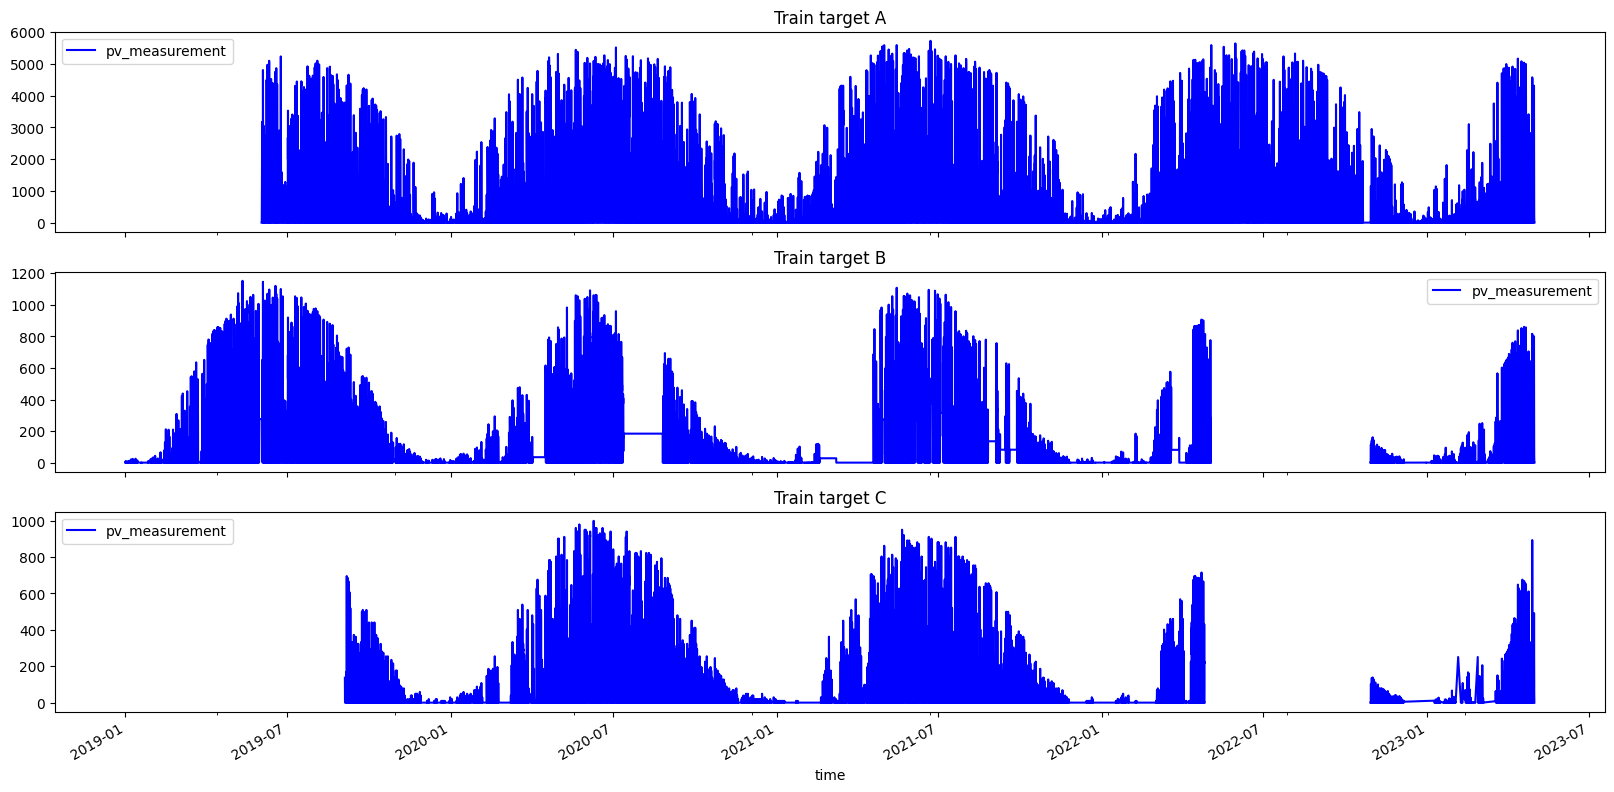

In [17]:
# Power production plots
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
train_a[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Train target A', color='blue')
train_b[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Train target B', color='blue')
train_c[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Train target C', color='blue')


<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

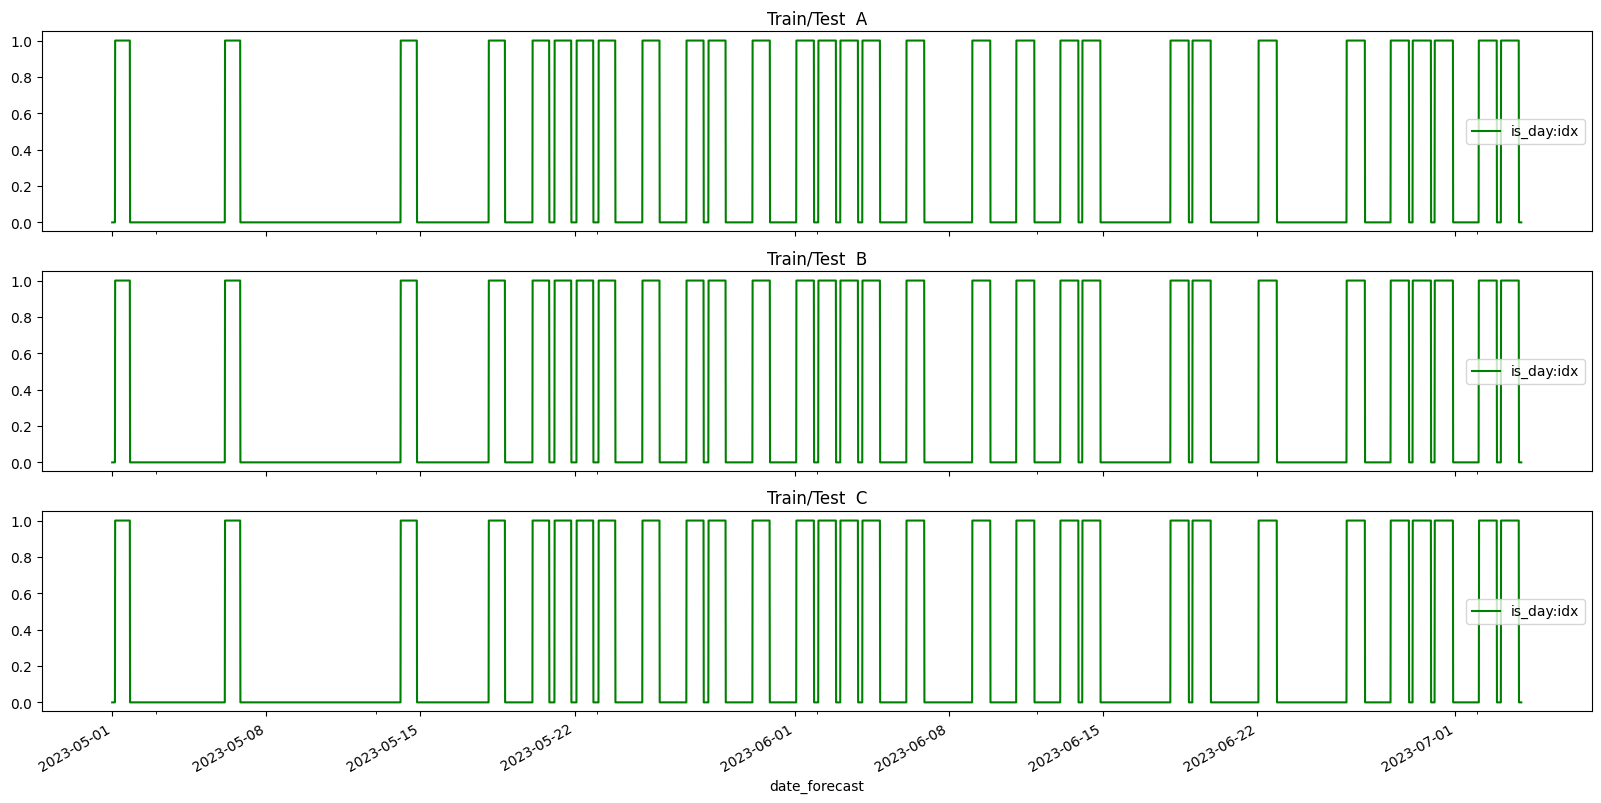

In [14]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'is_day:idx'
# X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
# X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

# X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
# X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

# X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
# X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

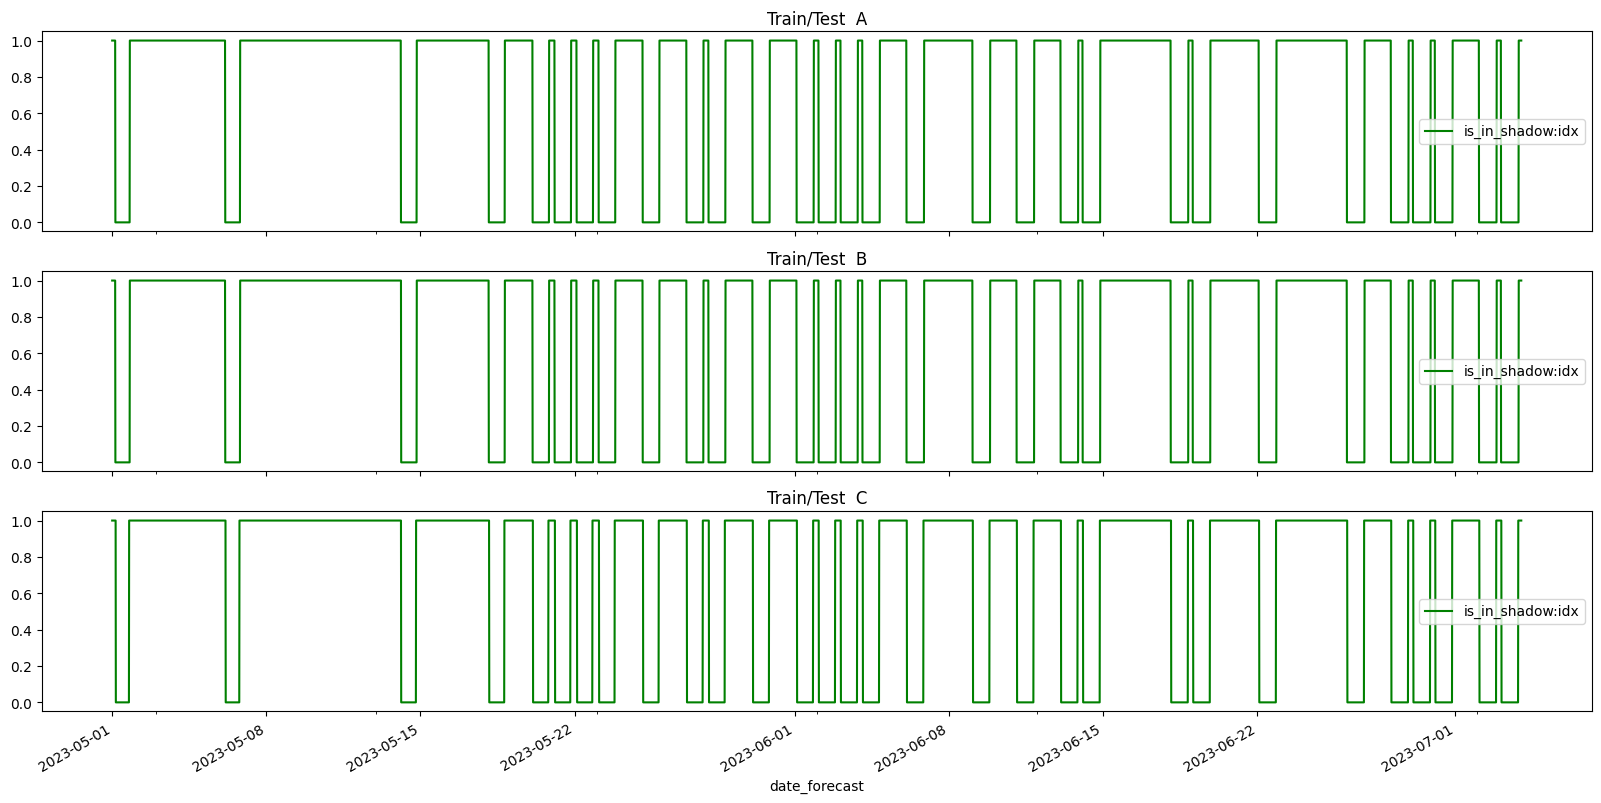

In [13]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'is_in_shadow:idx'
# X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
# X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

# X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
# X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

# X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
# X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

We present some heatmaps of the correlation matrices in order to get an impression of redundancies (?).

/Users/johanvikmathisen/Desktop/Fag/Matematikk/Solar-Energy-Prediction/.venv/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


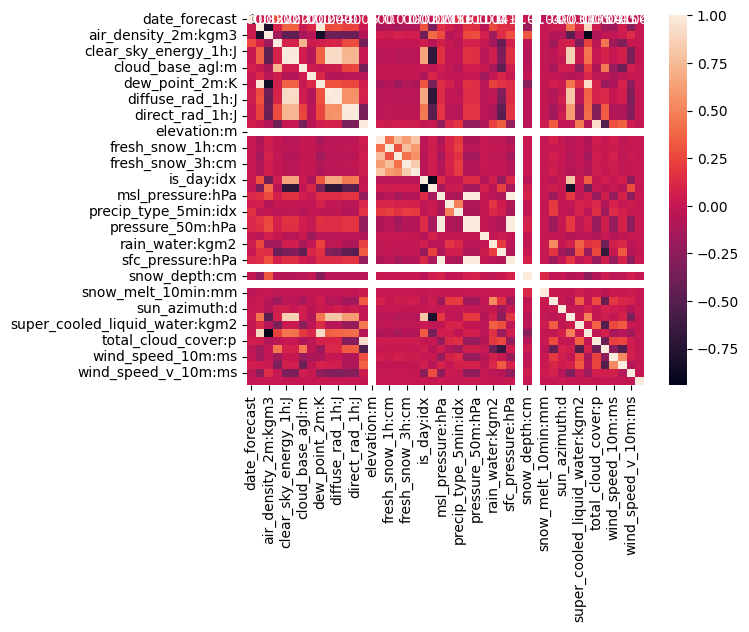

In [6]:
#correlation matrix and heatmap

corr = X_train_observed_a.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

# Linear correlations of features

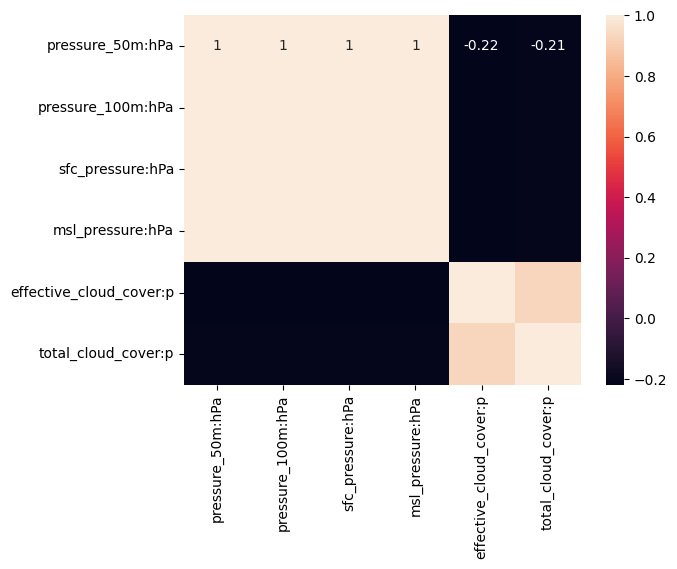

In [7]:

corr_check = X_train_observed_a[['pressure_50m:hPa', 'pressure_100m:hPa','sfc_pressure:hPa','msl_pressure:hPa', 'effective_cloud_cover:p', 'total_cloud_cover:p']]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

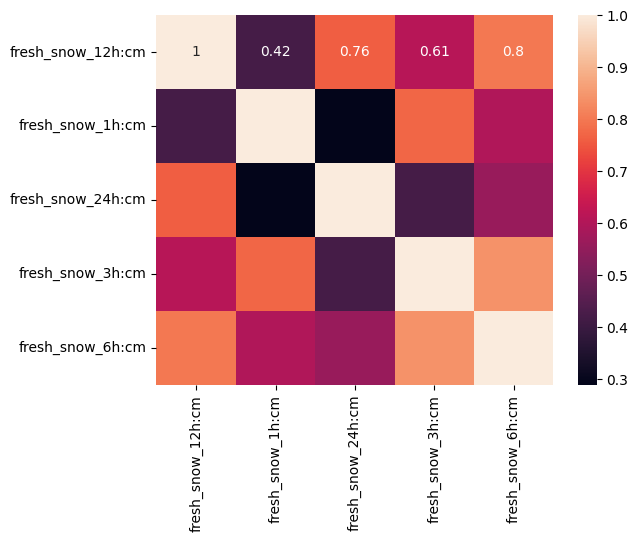

In [8]:
check_list = ['fresh_snow_12h:cm','fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
corr_check = X_train_observed_a[check_list]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

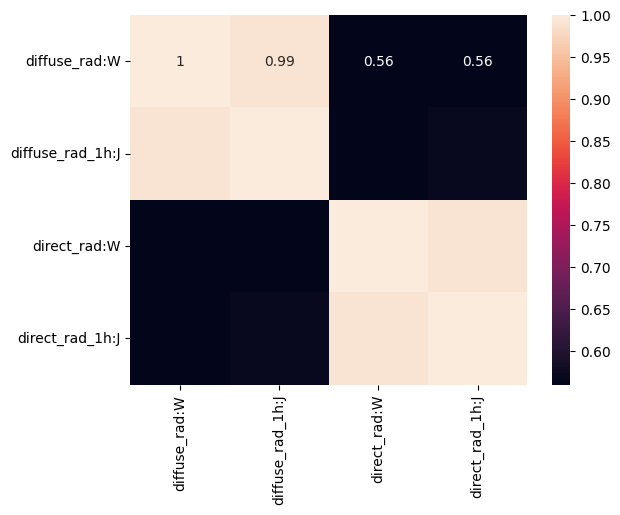

In [16]:
# check_list = ['diffuse_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J']
check_list = ['diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']

corr_check = X_train_observed_a[check_list]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

In [10]:
#Code used to make merged datasets:

#Make merged datasets

#add location as feature:
X_test_estimated_a['location'] = 'A'
X_test_estimated_b['location'] = 'B'
X_test_estimated_c['location'] = 'C'

frames = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

X_test_estimated_merge = pd.concat(frames)

# sort by date_forecast
X_test_estimated_merge = X_test_estimated_merge.sort_values(by= 'date_forecast')

# X_test_estimated_merge.to_parquet(path = 'merge/X_test_estimated_merge.parquet')

# Initial mistakes

Sorted all the combined data on time. Gave A,B,C,A,B,C.... The predictions were then evaluated against the true Y values which came in sequence A,A,A.., B,B,B...C,C,C.. This lead to stupidly bad results (800 ish).


Extreme underfitting, 100 iterations, 1 layer depth, learning rate 1.



# Model 1: Cat Boost

1. Finetuned submission:

Subset of features + Location.

['date_forecast', 'air_density_2m:kgm3',
                    'clear_sky_energy_1h:J',
                    'dew_point_2m:K',
                    'diffuse_rad:W', 'direct_rad:W',
                    'effective_cloud_cover:p', 'is_in_shadow:idx',
                    'precip_5min:mm',
                    'pressure_100m:hPa',
                    'relative_humidity_1000hPa:p',
                    'sun_azimuth:d',
                    'sun_elevation:d', 't_1000hPa:K',
                    'visibility:m',
                    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                    'location']

Not normalized.

`iterations = 5000, depth = 5, learning_rate =0.15, loss_function ='MAE'`

Local score: 88 ish

Score: 162.88068

# Normalization

# Feature engineering